In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data65


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [3]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
  Using cached https://mirror.baidu.com/pypi/packages/d1/41/e6495bd7d3781cee623ce23ea6ac73282a373088fcd0ddc809a047b18eae/beautifulsoup4-4.9.3-py3-none-any.whl (115 kB)
  Using cached https://mirror.baidu.com/pypi/packages/36/69/d82d04022f02733bf9a72bc3b96332d360c0c5307096d76f6bb7489f7e57/soupsieve-2.2.1-py3-none-any.whl (33 kB)
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [4]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [5]:
import paddle as pdl
import numpy as np
import cv2 as cv
from tqdm import tqdm
import paddle.vision.transforms as T

transform = T.Normalize(mean = [127.5], std = [127.5])
training_set = pdl.vision.datasets.MNIST(mode = 'train', transform = transform)
testing_set = pdl.vision.datasets.MNIST(mode = 'test', transform = transform)
print('Num of training set: {}, num of testing set: {}'.format(len(training_set), len(testing_set)))
# data set and packages(partly) has been loaded

Num of training set: 60000, num of testing set: 10000


In [6]:
# type of training_set is an object list containing 60000 images message
# which is saved as a 2 dimensions array(but it has a shell) and a 1x1 array
# take training_set[0] for example, it is [[2 dimensions array], [5]]


import matplotlib.pyplot as plt
plt.figure()
plt.imshow(training_set[0][0][0], cmap = plt.cm.binary)# it has a shell so we need to add a '[0]' to peel off its shell
plt.show()


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'col

<Figure size 640x480 with 1 Axes>

In [7]:
# neural network model net1
net1 = pdl.nn.Sequential(
    pdl.nn.Flatten(), pdl.nn.Linear(784, 100), pdl.nn.ReLU(),
    pdl.nn.Linear(100, 100), pdl.nn.ReLU(),
    pdl.nn.Linear(100, 10), pdl.nn.Softmax()
)
# convolution neural network model net2
net2 = pdl.nn.Sequential(
    pdl.nn.Conv2D(1, 6, (5, 5)), pdl.nn.MaxPool2D(kernel_size = 2),
    pdl.nn.Conv2D(6, 16, (5, 5)), pdl.nn.MaxPool2D(kernel_size = 2),
    pdl.nn.Flatten(), pdl.nn.Linear(256, 120),
    pdl.nn.Linear(120, 60),
    pdl.nn.Linear(60, 10),
    pdl.nn.Softmax()
)


In [8]:
# 执行这个前先执行上一块，执行了这个以后就可以加载之前训练好的参数了，不用再重新训练了
model1 = pdl.Model(net1, inputs=[pdl.static.InputSpec(shape=[-1, 28, 28], dtype='float32', name='image')])
model2 = pdl.Model(net2, inputs=[pdl.static.InputSpec(shape=[-1, 28, 28], dtype='float32', name='image')])
model1.summary((1, 784))
model2.summary((1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Flatten-1         [[1, 784]]            [1, 784]              0       
   Linear-1          [[1, 784]]            [1, 100]           78,500     
    ReLU-1           [[1, 100]]            [1, 100]              0       
   Linear-2          [[1, 100]]            [1, 100]           10,100     
    ReLU-2           [[1, 100]]            [1, 100]              0       
   Linear-3          [[1, 100]]            [1, 10]             1,010     
   Softmax-1         [[1, 10]]             [1, 10]               0       
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
-----------------------------------------------------------------------

{'total_params': 41282, 'trainable_params': 41282}

In [9]:
model1.prepare(pdl.optimizer.Adam(learning_rate = 0.001,
parameters = net1.parameters()),
pdl.nn.CrossEntropyLoss(),
pdl.metric.Accuracy())

model2.prepare(pdl.optimizer.Adam(learning_rate = 0.001,
parameters = net2.parameters()),
pdl.nn.CrossEntropyLoss(),
pdl.metric.Accuracy())

model1.fit(training_set, testing_set, epochs = 10, batch_size = 128, verbose = 1)
result1 = model1.evaluate(testing_set, verbose = 1)
model2.fit(training_set, testing_set, epochs = 10, batch_size = 128, verbose = 1)
result2 = model2.evaluate(testing_set, verbose = 1)
print(result1, result2)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/10
step  20/469 [>.............................] - loss: 1.9289 - acc: 0.4215 - ETA: 5s - 12ms/st

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step  30/469 [>.............................] - loss: 1.8947 - acc: 0.4633 - ETA: 5s - 12ms/stepstep 469/469 [==============================] - loss: 1.7323 - acc: 0.6948 - 12ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 79/79 [==============================] - loss: 1.6656 - acc: 0.7630 - 10ms/step         
Eval samples: 10000
Epoch 2/10
step 469/469 [==============================] - loss: 1.7713 - acc: 0.7614 - 13ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 79/79 [==============================] - loss: 1.6695 - acc: 0.7684 - 9ms/step         
Eval samples: 10000
Epoch 3/10
step 469/469 [==============================] - loss: 1.4870 - acc: 0.8935 - 12ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step

In [10]:
model1.save('finetuning/mnist_NN')
model2.save('finetuning/mnist_LeNet')
# 结果已经保存

In [11]:
predict1 = model1.predict(testing_set)
predict2 = model2.predict(testing_set)
# 经观察这些结果每一个都是预测的概率，需要提取出最大的一个作为预测结果，另外，外面依然有层壳

Predict begin...
step 10000/10000 [==============================] - 2ms/step        
Predict samples: 10000
Predict begin...
step 10000/10000 [==============================] - 2ms/step        
Predict samples: 10000


In [12]:
def show_img(img, predict):
    plt.figure()
    plt.title('predict: {}'.format(predict))
    plt.imshow(img.reshape([28,28]), cmap=plt.cm.binary)
    plt.show()

[ 513 1026 1539 2052 2565]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


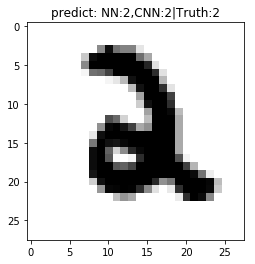

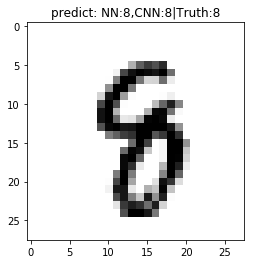

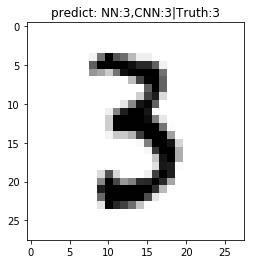

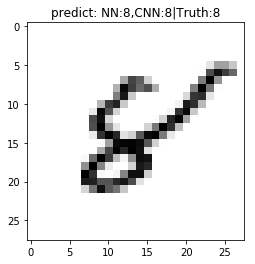

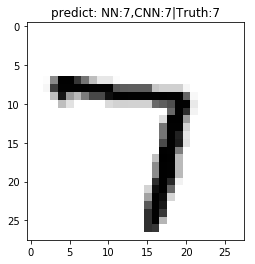

In [13]:
import random
indexs = random.randint(0, 2000) * np.array(range(1, 6))
print(indexs)

for idx in indexs:
    show_img(testing_set[idx][0], 'NN:{},CNN:{}|Truth:{}'.format(np.argmax(predict1[0][idx]), np.argmax(predict2[0][idx]), testing_set[idx][1][0]))


In [15]:
# 加载自己写的图片进行预测，记得先执行上面的两个网络建模模块
model1.load('finetuning/mnist_NN')
model2.load('finetuning/mnist_LeNet')

import os
import PIL
import matplotlib.pyplot as plt
number = 10
dir_path = r"dig10"
files = os.listdir(dir_path)
# print(files)
for idx in range(number):
    if('0'<=files[idx][0]<='9'):
        image_path = dir_path + '/' + files[idx]
        image = PIL.Image.open(image_path)
        # plt.imshow(image)
        # plt.show()
        image = image.convert("L")
        image = image.resize((28, 28), PIL.Image.ANTIALIAS)
        image = np.array(image).reshape(1, 1, 28, 28).astype(np.float32)
        image = 255 - image #反相操作！非常重要！
        image = image / 255.0 * 2.0 - 1.0
        pred1 = model1.predict_batch(image)
        pred2 = model2.predict_batch(image)
        # show_img(image,'NN:{}, LeNet-5:{}'.format(np.argmax(pred1), np.argmax(pred2)))
        print("神经网络预测数字为：{}".format(np.argmax(pred1)),end=",")
        print("卷积神经网络预测数字为：{}".format(np.argmax(pred2)))
        print("实际数字为：{}".format(files[idx].split(".")[0]))

神经网络预测数字为：8,卷积神经网络预测数字为：1
实际数字为：1
神经网络预测数字为：4,卷积神经网络预测数字为：4
实际数字为：4
神经网络预测数字为：5,卷积神经网络预测数字为：5
实际数字为：5
神经网络预测数字为：2,卷积神经网络预测数字为：2
实际数字为：2
神经网络预测数字为：0,卷积神经网络预测数字为：0
实际数字为：0
神经网络预测数字为：3,卷积神经网络预测数字为：7
实际数字为：7
神经网络预测数字为：8,卷积神经网络预测数字为：8
实际数字为：8
神经网络预测数字为：6,卷积神经网络预测数字为：6
实际数字为：6
神经网络预测数字为：3,卷积神经网络预测数字为：3
实际数字为：3
神经网络预测数字为：8,卷积神经网络预测数字为：8
实际数字为：9


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 